<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/ClasificadorBinario_resnet18_BalanceoImblearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Binario

## Librerías

In [23]:
!pip install fastai -Uq

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     |████████████████████████████████| 197 kB 16.1 MB/s 
     |████████████████████████████████| 60 kB 8.5 MB/s 


{'restart': True, 'status': 'ok'}

In [4]:
from fastai.vision.all import *

## Dataset

En este caso estamos usando el dataset que ha sido preprocesados mediante el método de recorte

In [5]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip


2022-06-16 17:28:19 URL:https://ucd31635f10f9ec82521f51f0630.dl.dropboxusercontent.com/cd/0/inline2/BnVoWVm5Cn0zcntlBFYmCHAW-kNMAPBnHOiu5kkbXFiDKKCQnCNL0uE7Jh5Wzd0iWTiKGHTj52AvpRgiytqXmf4hhl3kdpu2KI4zLwLVkP1QFPI2GzsHRW0EfpxHRN6jDz8VNE9Xr1KMw71PnAOW4TnayVfm0jotKsGILENuGTS6vxBhqdE0rcs7O-LH365O_3nQu0lgdCF9YKpXjtytOa4nnF6iZaUr6oiFtCJaXfFee1UOA0sPtlA9CbvgYNtd_HEvmx6WxVFWNX9BZrUD-OXZ79F28BbFDc_l_Xx2REpFnKJDzmc-vSmQkY77DRGT1CjcwhRnPnOkxJ9D9B7Vh_69DhcnYEzlWpADSWa4M7qNQMnJhflUVLWfNUwZHBpevlheLIinGce7S-beceCd95qr_hpjJz4rU9VtJKSn1Nf4-A/file [138777773/138777773] -> "train.zip" [1]
2022-06-16 17:28:23 URL:https://uc24428f0b4e4599144ceb5651d4.dl.dropboxusercontent.com/cd/0/inline2/BnVDQrIEnD3JzNpkc_7sD4afHCjtVEX_4k8PeYj-il5NqY_a1YCUPrK1AE0zDBlKcEdfImGWxI1FmgznnSyc2F5DzvHWooYRkn4FL-3PeSWkuJkI7tX1LD65Lw5O_547uzrLanTpMRhtWVSt1NhzBZureNiwFs0SlNL8byIRjPgYtAE9g_KvE9SDQqIQKhmoz5nMbKrUHY67oFaEb58uxgJnAOfv46BG30Kvqk8PEeUu9fsHUe8wiLQZ43PNfHxn9tso0naYFETBanV3a-MNKvNUlnV8Yht-8Z4EnvQVJfXWGxUoJQs0DtsmDB3sVprFg0j

In [3]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

Tenemos que cambiar la estructura del dataset


```.
└── dataset
    ├── train
    │   ├── normal
    │   └── enfermedad
    ├── test
    │   ├── normal
    │   └── enfermedad
    └── validation
        ├── normal
        └── enfermedad
```

Para ello usaremos el archivo csv de cada conjunto para mover cada imagen a donde corresponda

In [6]:
#Método para crear estructura de directorios
def crearEstructura(nombreDataset, clases):
  !mkdir "$nombreDataset"
  !mkdir "$nombreDataset"/test
  !mkdir "$nombreDataset"/train
  !mkdir "$nombreDataset"/val
  for x in clases:
    !mkdir "$nombreDataset"/train/"$x"
    !mkdir "$nombreDataset"/test/"$x"
    !mkdir "$nombreDataset"/val/"$x"

In [7]:
crearEstructura('dataset', ['normal', 'enfermedad'])

Creamos un path que apunte a la carpeta donde vamos a tener el dataset estructurado posteriormente:

In [8]:
path = Path('dataset/')

In [9]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [53]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [54]:
#1519 tienen enfermedad y 401 no la tienen
df_train['Disease_Risk'].value_counts()

1    1519
0     401
Name: Disease_Risk, dtype: int64

In [12]:
df_val['Disease_Risk'].value_counts() #506 - 134
df_test['Disease_Risk'].value_counts()

1    506
0    134
Name: Disease_Risk, dtype: int64

Una vez creada la estructura mencionada antes movemos las imágenes a la carpeta que corresponda. Ahora en la función moverImg() debemos copiar las imagenes en vez de moverlas ya que algunas se van a duplicar. También debemos dar un nombre random cada vez para conseguir que se dupliquen y no se sobreescriban cada vez.

In [13]:
import shutil
import uuid

def moverImg(df, pathO, pathD):
  for id, enf in zip(df['ID'], df['Disease_Risk']):
    if(int(enf)==0):
        shutil.copy(pathO + '/' + str(id) + '.png', pathD + '/normal/' + str(uuid.uuid1()) + '.png')
    else:
        shutil.copy(pathO + str(id) + '.png', pathD + '/enfermedad/' + str(uuid.uuid1()) + '.png')

## Balanceo

### Balanceando el conjunto de entrenamiento con la librería Imblearn:

Duplicaremos de forma aleatoria las intancias del dataframe de train, después moveremos la imágenes en función del dataset.


In [58]:
y = df_train.Disease_Risk
X = df_train.drop('Disease_Risk', axis=1)

In [59]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = RandomOverSampler(sampling_strategy=0.50) #Aumentaremos hasta la mitad de lo que es la clase mayoritaria (759)
under = RandomUnderSampler(sampling_strategy=1) #clase mayoriataria
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)

In [60]:
from collections import Counter

# evaluate pipeline
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 759, 1: 759})


In [61]:
X['Disease_Risk'] = y

In [62]:
df_train = X

In [63]:
len(df_train[df_train['Disease_Risk']==1].ID.unique())

759

In [64]:
len(df_train[df_train['Disease_Risk']==0].ID.unique())

401

**Ahora que ya tenemos la estructura deseada empezamos a construir el modelo:**

In [65]:
moverImg(df_train, str(trainPath) + '/Training/', str(path)  + '/train')
moverImg(df_test, str(testPath) + '/Test/', str(path)  + '/test')
moverImg(df_val, str(valPath) + '/Validation/', str(path)  + '/val')

In [66]:
len(Path(trainPath/'Training').ls()) #1921
len(Path(testPath/'Test').ls())      #640
len(Path(valPath/'Validation').ls()) #640

640

In [67]:
len(Path('dataset/train/normal').ls()) #401

759

## Cargando el dataset

In [68]:
db = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(train_name='train', valid_name='val'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))

In [69]:
dls = db.dataloaders(path,bs=128)

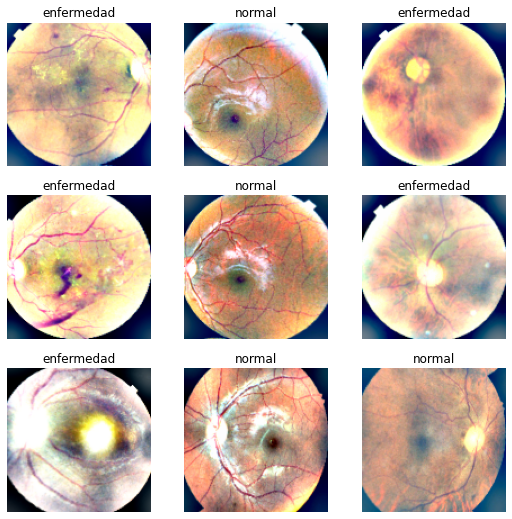

In [ ]:
dls.show_batch()

In [70]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')  
]

In [71]:
learn = cnn_learner(dls,resnet18,metrics=accuracy,cbs=callbacks).to_fp16()

/usr/local/lib/python3.7/dist-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

SuggestedLRs(minimum=0.012022644281387329, steep=0.0010000000474974513, valley=0.0012022644514217973, slide=0.007585775572806597)

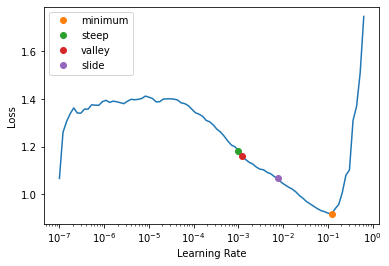

In [72]:
learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Entrenamos el modelo

epoch,train_loss,valid_loss,accuracy,time
0,1.032761,0.984868,0.764063,00:11


Better model found at epoch 0 with valid_loss value: 0.9848681688308716.


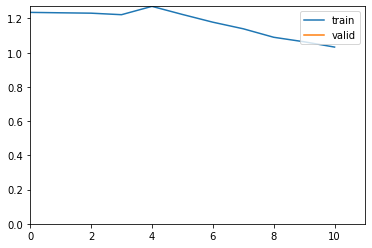

epoch,train_loss,valid_loss,accuracy,time
0,0.705140,0.733329,0.765625,00:08
1,0.659517,0.766996,0.721875,00:07
2,0.650348,0.747943,0.710938,00:07
3,0.624690,0.684781,0.746875,00:07
4,0.601628,0.709019,0.743750,00:07
5,0.570941,0.708847,0.746875,00:08
6,0.549975,0.704904,0.751562,00:07
7,0.523972,0.672368,0.759375,00:07
8,0.511463,0.677216,0.770312,00:07
9,0.485421,0.620265,0.789062,00:07


Better model found at epoch 0 with valid_loss value: 0.7333288192749023.


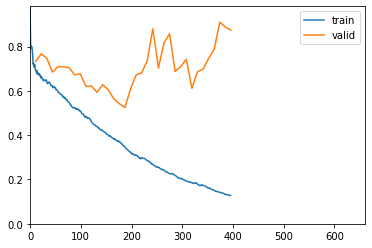

Better model found at epoch 3 with valid_loss value: 0.6847814321517944.
Better model found at epoch 7 with valid_loss value: 0.6723681092262268.
Better model found at epoch 9 with valid_loss value: 0.6202651262283325.
Better model found at epoch 11 with valid_loss value: 0.5937662720680237.
Better model found at epoch 14 with valid_loss value: 0.5642167329788208.
Better model found at epoch 15 with valid_loss value: 0.5422252416610718.
Better model found at epoch 16 with valid_loss value: 0.5249520540237427.
No improvement since epoch 16: early stopping


In [73]:
learn.fine_tune(60,base_lr=1e-3)

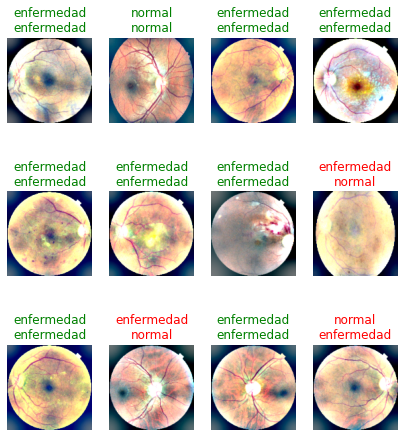

In [74]:
learn.show_results(max_n=12, figsize=(7,8))

Exportamos el modelo

In [75]:
learn.to_fp32()
learn.export('Binario_resnet18_BalanceoImblearn.pkl')

## Evaluando el modelo

In [76]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(256),
                 batch_tfms=aug_transforms(size=128,min_scale=0.75))
dlsTest = dbTest.dataloaders(path,bs=128)

In [77]:
learn.dls = dlsTest

El valor de la función de perdida es de 0.29 y su accuracy es del 86%.

In [78]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.8609374761581421.


(#2) [0.29445984959602356,0.8609374761581421]

## Interpretación del modelo

In [79]:
learn.dls=dls

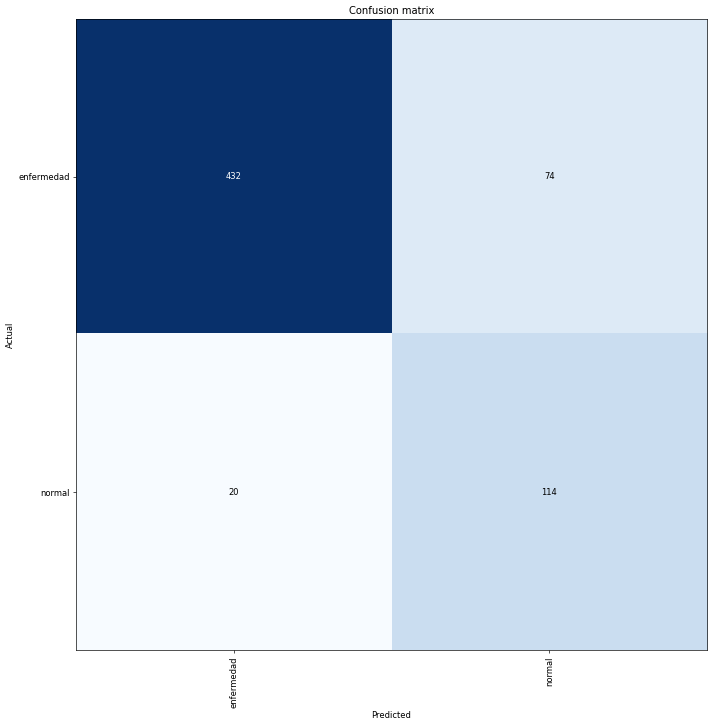

In [80]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)